# Imports

In [1]:
# Ignore warnings from UMAP
import warnings
warnings.filterwarnings('ignore')

# GPU Info

In [2]:
gpu_info = !nvidia-smi
gpu_info = '\n'.join(gpu_info)
if gpu_info.find('failed') >= 0:
  print('Not connected to a GPU')
else:
  print(gpu_info)

Thu Dec 16 20:49:22 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 495.44       Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   40C    P0    27W / 250W |      0MiB / 16280MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

# Download Dataset

In [3]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


In [4]:
!mkdir /content/dataset

In [5]:
!unzip '/content/drive/MyDrive/Mestrado/datasets/brain_stroke/brain_data.zip' -d '/content/dataset'

Archive:  /content/drive/MyDrive/Mestrado/datasets/brain_stroke/brain_data.zip
  inflating: /content/dataset/Brain_Data_Organised/Test/Normal/100 (20).jpg  
  inflating: /content/dataset/Brain_Data_Organised/Test/Normal/100 (21).jpg  
  inflating: /content/dataset/Brain_Data_Organised/Test/Normal/100 (22).jpg  
  inflating: /content/dataset/Brain_Data_Organised/Test/Normal/100 (23).jpg  
  inflating: /content/dataset/Brain_Data_Organised/Test/Normal/100 (24).jpg  
  inflating: /content/dataset/Brain_Data_Organised/Test/Normal/100 (25).jpg  
  inflating: /content/dataset/Brain_Data_Organised/Test/Normal/100 (26).jpg  
  inflating: /content/dataset/Brain_Data_Organised/Test/Normal/100 (28).jpg  
  inflating: /content/dataset/Brain_Data_Organised/Test/Normal/100 (29).jpg  
  inflating: /content/dataset/Brain_Data_Organised/Test/Normal/100 (30).jpg  
  inflating: /content/dataset/Brain_Data_Organised/Test/Normal/100 (5).jpg  
  inflating: /content/dataset/Brain_Data_Organised/Test/Normal/1

# Hyperparameters Setup

In [6]:
IMAGE_SIZE = 224
BATCH_SIZE = 16
INPUT_SHAPE = (IMAGE_SIZE, IMAGE_SIZE, 3)
EPOCHS = 100
NUM_CLASSES = 2
CLASSES = ["Normal", "Stroke"]

In [7]:
import keras 
import tensorflow as tf

LOSS = tf.keras.losses.BinaryCrossentropy() # Not un-weighted 
METRICS = [
      keras.metrics.CategoricalAccuracy(name="accuracy"),
      keras.metrics.BinaryAccuracy(name='BinaryAccuracy'),
      keras.metrics.Precision(name='precision'),
      keras.metrics.Recall(name='recall'),
      keras.metrics.AUC(name='auc'),
]
OPTIMIZER = tf.keras.optimizers.Adam(learning_rate = 0.001, beta_1 = 0.9, beta_2 = 0.999)

# Dataset Setup

In [8]:
import os

DF_TRAIN = '/content/dataset/Brain_Data_Organised/Train'
DF_TEST  = '/content/dataset/Brain_Data_Organised/Test'

path, dirs, files = next(os.walk(DF_TRAIN + "/Stroke"))
file_count = len(files)
print('Stroke:', file_count)
path, dirs, files = next(os.walk(DF_TRAIN + "/Normal"))
file_count = len(files)
print('Non-Stroke:', file_count)

Stroke: 825
Non-Stroke: 1426


In [9]:
from keras.preprocessing.image import ImageDataGenerator

train_gen = ImageDataGenerator(validation_split = 0.2)
                              #  rotation_range = 0.2)
test_gen  = ImageDataGenerator()

# load training and validating images from directory
train_set = train_gen.flow_from_directory(DF_TRAIN,
                                          subset = 'training',
                                          seed = 956,
                                          batch_size = BATCH_SIZE,
                                          target_size = (IMAGE_SIZE, IMAGE_SIZE)
                                          )

valid_set = train_gen.flow_from_directory(DF_TRAIN,
                                          subset = 'validation',
                                          seed = 343,
                                          batch_size = BATCH_SIZE,
                                          target_size = (IMAGE_SIZE, IMAGE_SIZE)
                                          )

test_set  = test_gen.flow_from_directory(DF_TEST,
                                         batch_size = BATCH_SIZE,
                                         target_size = (IMAGE_SIZE, IMAGE_SIZE)
                                         )

STEP_SIZE_TRAIN = train_set.n // train_set.batch_size
STEP_SIZE_VALID = valid_set.n // valid_set.batch_size

Found 1801 images belonging to 2 classes.
Found 450 images belonging to 2 classes.
Found 250 images belonging to 2 classes.


# Show Image Samples

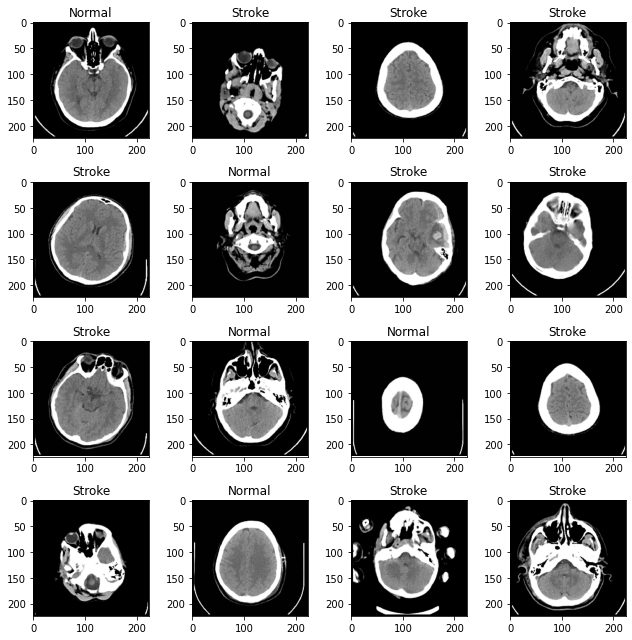

In [10]:
# show images from dataset
import matplotlib.pyplot as plt

images, labels = next(test_set)
labels = labels.argmax(axis=1)
fig, axes = plt.subplots(4, 4, figsize = (9, 9))

axes = axes.flatten()
for img, label, ax in zip(images, labels, axes):
    ax.imshow(img.astype("uint8"))
    ax.set_title(CLASSES[label.astype(int)])
plt.tight_layout()
plt.show()

# Experiments

## Auxiliar Functions

**Training**

In [11]:
def get_callbacks(model_name):
    callbacks = []
    tensor_board = tf.keras.callbacks.TensorBoard(log_dir='./logs', histogram_freq=0)
    callbacks.append(tensor_board)
    checkpoint = tf.keras.callbacks.ModelCheckpoint(filepath=f'model.{model_name}.h5', verbose=1, monitor='val_loss', mode='min', save_best_only=True)
    callbacks.append(checkpoint)
    anne = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=2, verbose=2, min_lr=0.0000001, min_delta=0.00001, mode='auto') 
    callbacks.append(anne)
    return callbacks

In [12]:
def plot_training_results(history):
  acc = history.history['accuracy']
  val_acc = history.history['val_accuracy']

  loss = history.history['loss']
  val_loss = history.history['val_loss']

  epochs_range = range(EPOCHS)

  plt.figure(figsize=(16, 8))
  plt.subplot(1, 2, 1)
  plt.plot(epochs_range, acc, label='Training Accuracy')
  plt.plot(epochs_range, val_acc, label='Validation Accuracy')
  plt.legend(loc='lower right')
  plt.title('Training and Validation Accuracy')

  plt.subplot(1, 2, 2)
  plt.plot(epochs_range, loss, label='Training Loss')
  plt.plot(epochs_range, val_loss, label='Validation Loss')
  plt.legend(loc='upper right')
  plt.title('Training and Validation Loss')
  plt.show()

**Predict**

In [13]:
def get_classes(data_set):
  f_classes = []
  idx_class = data_set.index_array
  for idc in idx_class:
    f_classes.append(data_set.classes[idc])
  return f_classes

**Plot manifolds**

In [14]:
# For plotting
import plotly.io as plt_io
import plotly.graph_objects as go
%matplotlib inline

def plot_2d(component1, component2,title):
    
    fig = go.Figure(data=go.Scatter(
        x = component1,
        y = component2,
        mode='markers',
        marker=dict(
            size=20,
            color=y, #set color equal to a variable
            # colorscale='Rainbow', # one of plotly colorscales
            # showscale=True,
            line_width=1,
        ),
        text=title
    ))
    fig.update_layout(title=title,title_x=0.5,margin=dict(l=100,r=100,b=100,t=100),width=1200,height=800)                 
    # fig.layout.template = 'plotly_dark'
    fig.show()

def plot_3d(component1,component2,component3,title):

    fig = go.Figure(data=[go.Scatter3d(
            x=component1,
            y=component2,
            z=component3,
            mode='markers',
            marker=dict(
                size=10,
                color=y,                # set color to an array/list of desired values
                # colorscale='Rainbow',   # choose a colorscale
                opacity=1,
                line_width=1
            )
        )])
    # tight layout
    fig.update_layout(title=title,title_x=0.5,margin=dict(l=50,r=50,b=50,t=50),width=1200,height=800)
    # fig.layout.template = 'plotly_dark'
    fig.show()

## ViT B32

### Build Model

In [15]:
!pip install -U vit-keras
!pip install -U tensorflow-addons

     |████████████████████████████████| 1.1 MB 8.1 MB/s 


In [16]:
# build vit model with 32 patch_size
from vit_keras import vit

base_model = vit.vit_b32(
        image_size = IMAGE_SIZE,
        activation = 'softmax',
        pretrained = True,
        include_top = False,
        pretrained_top = False,
        classes = NUM_CLASSES)
base_model.trainable = True

x = base_model.output
predictions = tf.keras.layers.Dense(NUM_CLASSES, activation = 'sigmoid', name = 'Final')(x)
model_vit = tf.keras.models.Model(name = "vit_b32", inputs = base_model.input, outputs = predictions)

OPTIMIZER = tf.keras.optimizers.Adam(learning_rate = 0.001, beta_1 = 0.9, beta_2 = 0.999)
model_vit.compile(loss = 'binary_crossentropy', optimizer = OPTIMIZER, metrics = METRICS)

353263616/353253686 [==============================] - 26s 0us/step


In [17]:
model_vit.summary()

Model: "vit_b32"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 embedding (Conv2D)          (None, 7, 7, 768)         2360064   
                                                                 
 reshape (Reshape)           (None, 49, 768)           0         
                                                                 
 class_token (ClassToken)    (None, 50, 768)           768       
                                                                 
 Transformer/posembed_input   (None, 50, 768)          38400     
 (AddPositionEmbs)                                               
                                                                 
 Transformer/encoderblock_0   ((None, 50, 768),        7087872   
 (TransformerBlock)           (None, 12, None, None))      

### Train Model

In [18]:
# train the model
from datetime import datetime

start = datetime.now()
print(datetime.now())

callbacks = get_callbacks('vitb32')
history_vit = model_vit.fit(train_set,
                            epochs = 2,
                            validation_data = valid_set,
                            callbacks = [callbacks])

end = datetime.now()
print(end-start)

2021-12-16 20:52:36.454336
Epoch 1/2
113/113 [==============================] - ETA: 0s - loss: 0.6199 - accuracy: 0.7041 - BinaryAccuracy: 0.7024 - precision: 0.7019 - recall: 0.7035 - auc: 0.7677
Epoch 00001: val_loss improved from inf to 0.82554, saving model to model.vitb32.h5
113/113 [==============================] - 55s 227ms/step - loss: 0.6199 - accuracy: 0.7041 - BinaryAccuracy: 0.7024 - precision: 0.7019 - recall: 0.7035 - auc: 0.7677 - val_loss: 0.8255 - val_accuracy: 0.6756 - val_BinaryAccuracy: 0.6733 - val_precision: 0.6781 - val_recall: 0.6600 - val_auc: 0.6558 - lr: 0.0010
Epoch 2/2
113/113 [==============================] - ETA: 0s - loss: 0.3217 - accuracy: 0.8790 - BinaryAccuracy: 0.8759 - precision: 0.8774 - recall: 0.8740 - auc: 0.9362
Epoch 00002: val_loss did not improve from 0.82554
113/113 [==============================] - 19s 165ms/step - loss: 0.3217 - accuracy: 0.8790 - BinaryAccuracy: 0.8759 - precision: 0.8774 - recall: 0.8740 - auc: 0.9362 - val_loss: 1

In [ ]:
!cp '/content/model.vitb32.h5' '/content/drive/MyDrive/Mestrado/datasets/brain_stroke/weights/model.vitb32.h5'

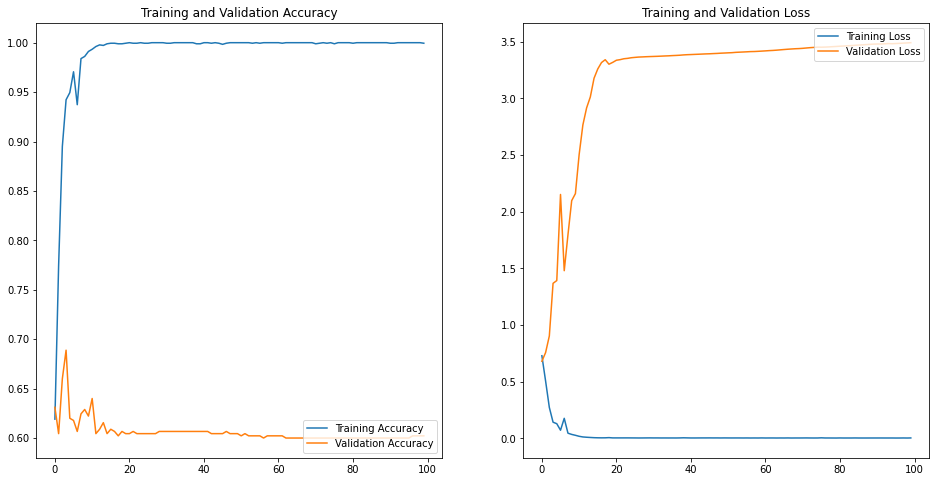

In [ ]:
plot_training_results(history_vit)

### Evaluate Model

In [19]:
# get results
test_set.reset()
results = model_vit.evaluate(test_set, steps = len(test_set), verbose = 1, return_dict = True)

16/16 [==============================] - 1s 71ms/step - loss: 0.9375 - accuracy: 0.7160 - BinaryAccuracy: 0.7160 - precision: 0.7143 - recall: 0.7200 - auc: 0.7319


In [20]:
# show results
print('ViT B32:')
print('---------------')
print("Accuracy:",(results['accuracy']))
print("Binary Accuracy:",(results['BinaryAccuracy']))
print("Precision:",(results['precision']))
print("Recall:",(results['recall']))
print("AUC:",(results['auc']))
print("F1 Score:",(2*((results['precision']*results['recall'])/((results['precision']+results['recall'])))))

ViT B32:
---------------
Accuracy: 0.7160000205039978
Binary Accuracy: 0.7160000205039978
Precision: 0.7142857313156128
Recall: 0.7200000286102295
AUC: 0.7318799495697021
F1 Score: 0.717131496877875


### Predict Images


Classification Report
              precision    recall  f1-score   support

      Normal       0.51      0.62      0.56       125
      Stroke       0.52      0.42      0.46       125

    accuracy                           0.52       250
   macro avg       0.52      0.52      0.51       250
weighted avg       0.52      0.52      0.51       250

Confusion Matrix
[[77 48]
 [73 52]]


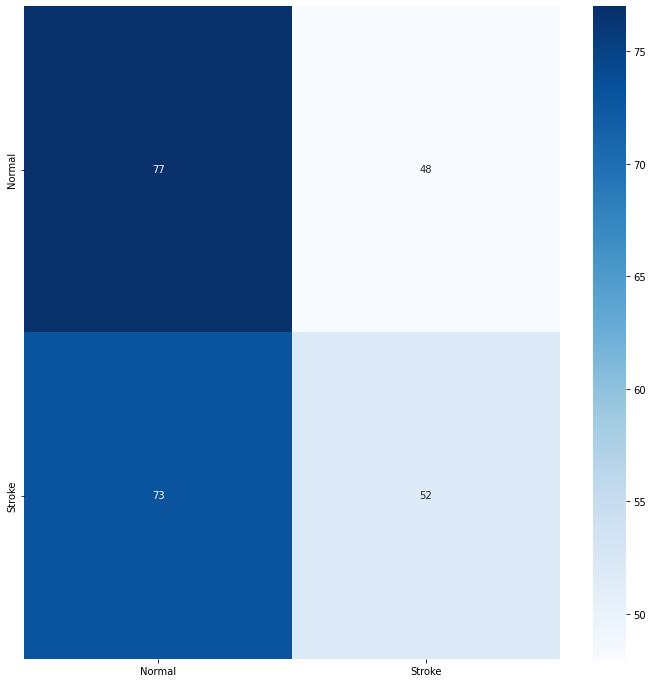

In [21]:
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import numpy as np

test_set.reset()
Y_pred_1 = model_vit.predict(test_set)
y_pred_1 = Y_pred_1.argmax(axis=1)

f_classes = []
idx_class = test_set.index_array
for idc in idx_class:
  f_classes.append(test_set.classes[idc])

print('\nClassification Report')
print(classification_report(f_classes, y_pred_1, target_names = CLASSES))

confusionmatrix = confusion_matrix(f_classes, y_pred_1)
print('Confusion Matrix')
print(confusionmatrix)

plt.figure(figsize = (12, 12))
sns.heatmap(confusionmatrix, cmap = 'Blues', annot = True, cbar = True, fmt="0.5g", xticklabels = CLASSES, yticklabels = CLASSES)

## Manifolds

### Create dataframe

In [22]:
from keras.applications.efficientnet import preprocess_input
from keras.preprocessing import image
import numpy as np

img_path = '/content/dataset/Brain_Data_Organised/Train/Stroke/97 (5).jpg'
img = image.load_img(img_path, target_size=(IMAGE_SIZE, IMAGE_SIZE))
img_data = image.img_to_array(img)
img_data = np.expand_dims(img_data, axis=0)
img_data = preprocess_input(img_data)

model_vit_notop = tf.keras.models.Model(inputs = model_vit.input,
                                        outputs = model_vit.get_layer("Transformer/encoder_norm").output)

vit_feature = model_vit_notop.predict(img_data)

print(vit_feature.shape)

(1, 50, 768)


In [23]:
# valid_set.reset()
# Y_pred_vit_notop = model_vit_notop.predict(valid_set)
train_set.reset()
Y_pred_vit_notop = model_vit.predict(train_set)
y_pred_vit_notop = Y_pred_vit_notop.argmax(axis=1)

vit_feature_list = []

for y_pred in y_pred_vit_notop:
  vit_feature_np = np.array(y_pred)
  vit_feature_flatten = vit_feature_np.flatten()
  vit_feature_list.append(vit_feature_flatten)

vit_feature_list_np = np.array(vit_feature_list)

In [24]:
# create dataframe with 300 features for each image
import pandas as pd

df = pd.DataFrame()  

# labels = get_classes(valid_set)
labels = get_classes(train_set)

columns = []
columns.append('label')
for i in range(len(vit_feature_flatten[:768])):
  columns.append("feature_" + str(i+1))
  i = i+1

df = pd.DataFrame(columns=columns)

for i in range(len(labels)):
  vit_feature = vit_feature_list_np[i]
  df.at[i, columns[0]] = labels[i] 
  for j in range(len(vit_feature[:768])):
    df.at[i, columns[j+1]] = vit_feature[j]

In [25]:
df.head()

,label,feature_1
0,0,0
1,1,0
2,1,0
3,0,0
4,0,0


In [26]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1801 entries, 0 to 1800
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   label      1801 non-null   object
 1   feature_1  1801 non-null   object
dtypes: object(2)
memory usage: 122.2+ KB


In [27]:
y = df.loc[:,'label'].values
x = df.loc[:,'feature_1':].values

In [28]:
from sklearn.preprocessing import StandardScaler
## Standardizing the data
x = StandardScaler().fit_transform(x)

### T-SNE

In [29]:
#TSNE
import time
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE

start = time.time()
pca_50 = PCA(n_components=50)
pca_result_50 = pca_50.fit_transform(x)
tsne = TSNE(random_state = 42, n_components=3,verbose=True, perplexity=20, n_iter=400).fit_transform(pca_result_50)
print('Duration: {} seconds'.format(time.time() - start))

ValueError: ignored

In [ ]:
plot_2d(tsne[:, 0],tsne[:, 1], "t-SNE projection of the dataset")

In [ ]:
plot_3d(tsne[:, 0],tsne[:, 1],tsne[:, 2], "t-SNE projection of the dataset")

### UMAP

In [ ]:
!pip install umap-learn[plot]

UMAP Unsupervised

In [31]:
#UMAP
import umap

# unsupervised
start = time.time()
reducer = umap.UMAP(random_state=42,n_components=3)
embedding = reducer.fit_transform(x)
print('Duration: {} seconds'.format(time.time() - start))

Duration: 32.61910939216614 seconds


In [32]:
plot_2d(reducer.embedding_[:, 0],reducer.embedding_[:, 1], "uMAP projection of the dataset")

In [33]:
plot_3d(reducer.embedding_[:, 0],reducer.embedding_[:, 1],reducer.embedding_[:, 2], "uMAP projection of the dataset")

UMAP Supervised

In [34]:
#UMAP
import umap

# supervised
start = time.time()
reducer = umap.UMAP(n_components = 3, n_neighbors = 20, verbose = True)
umap_transformer = reducer.fit(x, labels)
embedding = umap_transformer.transform(x)
print('Duration: {} seconds'.format(time.time() - start))

UMAP(n_components=3, n_neighbors=20, verbose=True)
Thu Dec 16 20:59:03 2021 Construct fuzzy simplicial set
Thu Dec 16 20:59:05 2021 Finding Nearest Neighbors
Thu Dec 16 20:59:05 2021 Finished Nearest Neighbor Search
Thu Dec 16 20:59:05 2021 Construct embedding


Epochs completed:   0%|            0/500 [00:00]

Thu Dec 16 20:59:16 2021 Finished embedding
Duration: 13.408711671829224 seconds


In [35]:
plot_2d(reducer.embedding_[:, 0],reducer.embedding_[:, 1], "UMAP projection of the dataset")

In [36]:
plot_3d(reducer.embedding_[:, 0],reducer.embedding_[:, 1],reducer.embedding_[:, 2], "UMAP projection of the dataset")